## Upgrade the Package `chbe444umd`
+ Upgrading will enable you to access its latest capabilities.
+ To install, run:
  >`%pip install chbe444umd`
+ To upgrade, run:
  >`%pip install --upgrade chbe444umd`
+ Restart the kernel after installing or upgrading.

# Reaction Rate Fields and Reactors

## 0. Introduction

This script plots the reaction rate field for the system A $\rightarrow$ B, A $\rightarrow$ C with autocatalytic kinetics, covered in the Module F workshop.

The kinetics of the reactions are as follows:

|Reaction                   |Rate expression|Units|
|:-------------------------:|:-------------------------------------------------:|:----|
|$r_1$  (A $\rightarrow$ B) | $k_1 C_A$                                         |$M/s$|
|$r_2$  (A $\rightarrow$ B) | $k_2 \frac{C_A^2 C_B^2}{K_1 + K_2 C_A C_B^2}$     |$M/s$|
|$r_3$  (A $\rightarrow$ C) | $k_3 C_A$                                         |$M/s$|

Note that, due to the stoichiometry, the rates of formation of A and B are given by:

$$
r_A = - k_1 C_A - k_2 \frac{C_A^2 C_B^2}{K_1 + K_2 C_A C_B^2} - k_3 C_A
$$

$$
r_B = k_1 C_A + k_2 \frac{C_A^2 C_B^2}{K_1 + K_2C_AC_B^2}
$$

Let us use the same rate constants we used in previous assignments involving this reaction system: $k_1 = 0.001 \ s^{-1}$, $k_2 = 10 \ M s^{-1}$, $k_3 = 0.1 \ s^{-1}$, $K_1 = 1 \ M^4$ and $K_2 = 40 \ M$

## 1. Specify Reaction System and Plot Rate Field

### 1.1 Specify reaction system

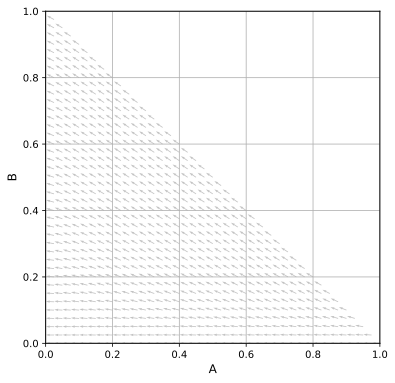

In [1]:
import chbe444umd as des

sysABC = des.ReactionSystem(
    component_ids=('A', 'B', 'C'),
    component_names={'A': 'A', 'B': 'B', 'C': 'C'},
    axes={'A': 0, 'B': 1},
    h_lim=[0, 1],
    v_lim=[0, 1],
    reactions=('r1', 'r2', 'r3'),
    stoich={'r1': {'A': -1, 'B': 1},
            'r2': {'A': -1, 'B': 1},
            'r3': {'A': -1, 'C': 1}},
    kinetics={'r1': lambda C: 0.001 * C['A'],
              'r2': lambda C: 10 * C['A']**2 * C['B']**2 / (1 + 40 * C['A'] * C['B']**2),
              'r3': lambda C: 0.1 * C['A']},
    inequality=lambda C: C['A'] + C['B'] - 1
)

%config InlineBackend.figure_format='svg'
%matplotlib inline

fig, ax, _ = sysABC.plot_rate_field(fsize=6, n_vec=41, arrow_scale=41)

## 2. Specify and Simulate Reactors

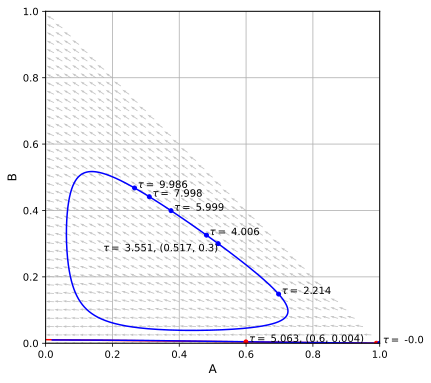

In [2]:
# PFR with a fresh feed at [1, 0]
pfr1 = des.Reactor(name='PFR1', flow_type='pfr', feed=[1, 0])
pfr1.simulate(system=sysABC, ax=ax, time_limit=60)

# CSTR with fresh feed at [1, 0]
cstr1 = des.Reactor(name='CSTR1', flow_type='cstr', feed=[1, 0], time=500)
cstr1.simulate(system=sysABC, ax=ax)

# Plot points
pfr1.plot_point(ax, x=0.6)
ax, point, text = cstr1.plot_point(ax, y=0.3, ha='right', va='top')
# ha: horizontal alignment, va: vertical alignment
pfr1.plot_point(ax, tau=0.1, annotate=False)  # do not annotate/label the point

import numpy as np
[cstr1.plot_point(ax, y=0.4, tau=t, annotation='tau') for t in np.linspace(0, 10, 6)]
# points should plot on upper portion of the circular CSTR curve near y = 0.4

fig

## 3. Perform annotations and attainable region (AR) constructions

### 3.1 Draw initial convex hull (draft of attainable region)

+ You can draw a tangent by requiring the tangency point to be near a given point. For this, specify a `near_point` and a horizontal distance (`distance_h` or `distance_x`) or vertical distance (`distance_v` or `distance_y`) from the `near_point`.
+ This feature is useful when reactor curves have multiple segments (e.g., CSTR from the fresh feed in this example), and multiple tangents are possible from the `from_point`.
+ For help, run:
  >`des.Reactor.plot_tangent`

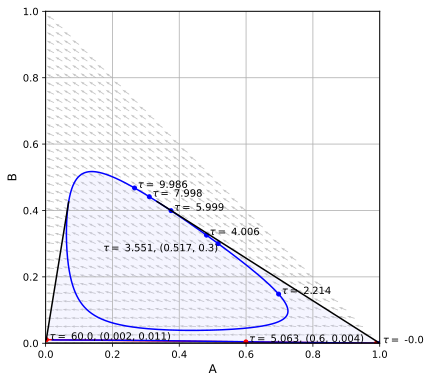

In [3]:
ax, tangent1 = cstr1.plot_tangent(ax, from_point=[1, 1e-6],
                                  near_point=[0.4, 0.6], distance_y = 0.2,
                                  tol=1e-3,
                                  linestyle='-', color='k')  # 'k' = black

pfr1.plot_point(ax, x=0, annotate='xy')
ax, tangent2 = cstr1.plot_tangent(ax, from_point=[0.002, 0.011],
                                  near_point=[0.1, 0.35], distance_x = 0.05,
                                  tol=1e-3,
                                  linestyle='-', color='k')  # 'k' = black

line1, = ax.plot([1, 0], [0, 0], 'k-')  # baseline from [0, 0] to [1, 0]
des.convexify(ax, boundaries=[pfr1, cstr1, tangent1, tangent2, line1],
              lw=0, color='#cdcdff', alpha=0.2)

fig

### 3.2 Revise convex hull (final attainable region)

+ Since rate vectors are pointing out at the northwest of the draft AR, we will need to draw a PFR to contain the vectors.
+ The PFR must be drawn from the point at which the tangent from the feed to the CSTR ends.
+ We can query the tangent object `tangent1` to get the exact coordinates of the feed of the new PFR.

In [4]:
X = tangent1.get_xdata()[1]
Y = tangent1.get_ydata()[1]
print(X, Y)

0.3333333333333333 0.4269692814127859


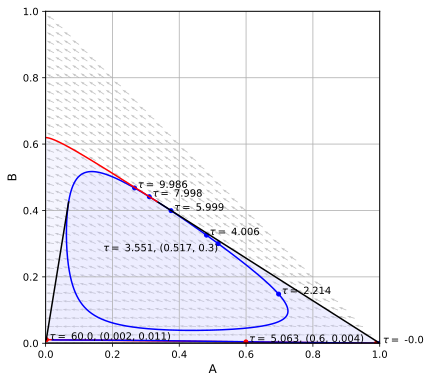

In [5]:
pfr2 = des.Reactor(name='PFR2', flow_type='pfr', feed=[X, Y])
pfr2.simulate(system=sysABC, ax=ax, time_limit=100)

des.convexify(ax, boundaries=[cstr1, pfr2, line1],
              lw=0, color='#cdcdff', alpha=0.2)

fig